# CRISPRi Repression Measurements

The following code uses ΔC$_t$ measurements from qPCR data to quantify the repression intensity of each CRISPRi perturbation. These values are calculated using the ΔΔC$_t$ method, using the $hcaT$ gene as a control RNA and a nontargeting construct as the control strain. These values are presented as relative repression, where 0 is no change in [mRNA], 1 would be a complete depletion of mRNA, and negative numbers correspond to increases in [mRNA] (a value of -1 would be a 2-fold increase).

6/28/22 - Ryan Otto
3/7/23 - Ryan Otto

### Import packages and libraries

In [1]:
import pickle
import numpy as np
import math
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plot_defaults
plot_defaults.change_defaults()

### Define relevant variables

In [2]:
date = '231012'
input_path = 'input_files'
figure_path = 'Figures'
output_path = 'intermediate_files'
gene_names = ['dapA', 'dapB', 'folA', 'thyA', 'glyA', 'gdhA', 'gltB', 'purN', 'purL']
file_dates = ['210603', '210401', '210427', '210704', '210708', '210716', '210719', '210910', '211210', '211215',
              '230303']

### Import data

In [3]:
strainID_sgRNA = {}  # Convert from strain ID to sgRNA identity
with open(f'{input_path}/strainID_to_sgrna.txt', mode='r') as file:
    lines = file.readlines()
    for line in lines:
        strain_sgRNA = line.split(':')
        strainID_sgRNA[strain_sgRNA[0]] = strain_sgRNA[1].strip()
gene_target_dict = {}  # Identify which knockdowns were measured in each experiment
with open(f'{input_path}/date_to_gene.txt', mode='r') as file:
    lines = file.readlines()
    for line in lines:
        date_genes = line.split(':')
        gene_target_dict[date_genes[0]] = []
        genes = date_genes[1].strip().split(',')
        for gene in genes:
            gene_target_dict[date_genes[0]].append(gene)
treatment_dict = {}  # Identify which strains were used in each experiment
with open(f'{input_path}/date_to_strainID.txt', mode='r') as file:
    lines = file.readlines()
    for line in lines:
        date_strains = line.split(':')
        treatment_dict[date_strains[0]] = []
        strains = date_strains[1].strip().split(',')
        for strain in strains:
            treatment_dict[date_strains[0]].append(strain)
ct_dict, no_temp_dict, gDNA_dict = {}, {}, {}  # Store all qPCR measurments for each gene and control
for file_date in file_dates:
    ct_dict[file_date], no_temp_dict[file_date], gDNA_dict[file_date] = {}, {}, {}
    with open(f'{input_path}/qPCR/{file_date}_qPCR_Results.csv', 'r') as f:
        f.readline()  # Skip header
        for line in f:
            sp = line.split(',')
            gene, strain, ct = sp[3], sp[5], sp[6]  # Extract relevant data
            if gene in gene_target_dict[file_date] and strain in treatment_dict[file_date]:
                if strain == 'no_temp':  # No template control data
                    if gene not in no_temp_dict[file_date]:
                        no_temp_dict[file_date][gene] = []
                    if ct:  # Sufficient amplification by cycle 40
                        no_temp_dict[file_date][gene].append(float(ct))
                    else:
                        no_temp_dict[file_date][gene].append(40)
                elif gene == 'gDNA':  # gDNA control data
                    if strainID_sgRNA[strain] not in gDNA_dict[file_date]:
                        gDNA_dict[file_date][strainID_sgRNA[strain]] = []
                    if ct:  # Sufficient amplification by cycle 40
                        gDNA_dict[file_date][strainID_sgRNA[strain]].append(float(ct))
                    else:
                        gDNA_dict[file_date][strainID_sgRNA[strain]].append(40)
                else:  # All other measurements
                    if gene not in ct_dict[file_date]:
                        ct_dict[file_date][gene] = {}
                    if strainID_sgRNA[strain] not in ct_dict[file_date][gene]:
                        ct_dict[file_date][gene][strainID_sgRNA[strain]] = []
                    if ct:  # Sufficient amplification by cycle 40
                        ct_dict[file_date][gene][strainID_sgRNA[strain]].append(float(ct))
                    else:
                        ct_dict[file_date][gene][strainID_sgRNA[strain]].append(40)

### Define analysis functions

In [4]:
def calc_mean_ct(ct_values_dict):
    """Calculates the mean, SEM, and std of Ct values.
    Arguments:
    ct_values_dict: Raw Ct values of technical replicates
    Returns:
    mean_dict: Average Ct values
    sem_dict: SEM of Ct values
    std_dict: Std of Ct values
    """
    mean_dict, sem_dict, std_dict = {}, {}, {}
    for file_date in ct_values_dict:
        mean_dict[file_date], sem_dict[file_date], std_dict[file_date] = {}, {}, {}
        for gene in ct_values_dict[file_date]:
            mean_dict[file_date][gene], sem_dict[file_date][gene], std_dict[file_date][gene] = {}, {}, {}
            for treatment in ct_values_dict[file_date][gene]:
                mean_dict[file_date][gene][treatment] = np.mean(ct_values_dict[file_date][gene][treatment])
                sem_dict[file_date][gene][treatment] = stats.sem(ct_values_dict[file_date][gene][treatment])
                std_dict[file_date][gene][treatment] = np.std(ct_values_dict[file_date][gene][treatment])
    return mean_dict, sem_dict, std_dict


def calc_delta_ct(ct_values_dict, ave_ct_dict, ave_ct_sem_dict, ave_ct_std_dict):
    """Calculates ΔCt values by normalizing each target gene to the reference gene hcaT
    Arguments:
    ct_values_dict: Raw Ct values of technical replicates
    ave_ct_dict: Average Ct values
    ave_ct_sem_dict: SEM of Ct values
    ave_ct_std_dict: Std of Ct values
    Returns:
    delta_ct_dict: Individual ΔCt values
    delta_ct_mean_dict: Average ΔCt values
    delta_ct_sem_dict: SEM of ΔCt values
    delta_ct_std_dict: Std of ΔCt values
    """
    delta_ct_dict, delta_ct_mean_dict, delta_ct_sem_dict, delta_ct_std_dict = {}, {}, {}, {}
    for file_date in ave_ct_dict:
        delta_ct_dict[file_date], delta_ct_mean_dict[file_date], delta_ct_sem_dict[file_date], \
                                                                    delta_ct_std_dict[file_date] = {}, {}, {}, {}
        for gene in ave_ct_dict[file_date]:
            if gene != 'hcaT':  # Don't need to compare hcaT to itself
                delta_ct_dict[file_date][gene], delta_ct_mean_dict[file_date][gene], \
                delta_ct_sem_dict[file_date][gene], delta_ct_std_dict[file_date][gene] = {}, {}, {}, {}
                for treatment in ave_ct_dict[file_date][gene]:
                    delta_ct_dict[file_date][gene][treatment] = [val - ave_ct_dict[file_date]['hcaT'][treatment]
                                                            for val in ct_values_dict[file_date][gene][treatment]]
                    delta_ct_mean_dict[file_date][gene][treatment] = ave_ct_dict[file_date][gene][treatment] \
                                                                   - ave_ct_dict[file_date]['hcaT'][treatment]
                    delta_ct_sem_dict[file_date][gene][treatment] = math.sqrt(
                                                                    ave_ct_sem_dict[file_date][gene][treatment]**2
                                                                  + ave_ct_sem_dict[file_date]['hcaT'][treatment]**2)
                    delta_ct_std_dict[file_date][gene][treatment] = math.sqrt(
                                                                    ave_ct_std_dict[file_date][gene][treatment]**2
                                                                  + ave_ct_std_dict[file_date]['hcaT'][treatment]**2)
    return delta_ct_dict, delta_ct_mean_dict, delta_ct_sem_dict, delta_ct_std_dict


def calc_deltadelta_ct(delta_ct_dict, delta_ct_mean_dict, delta_ct_sem_dict, delta_ct_std_dict, gene_list):
    """Calculates ΔΔCt values by normalizing each target strain to the reference nontargeting strain
    Arguments:
    delta_ct_dict: Individual ΔCt values
    delta_ct_mean_dict: Average ΔCt values
    delta_ct_sem_dict: SEM of ΔCt values
    delta_ct_std_dict: Std of ΔCt values
    gene_list: All target genes in this exepriment
    Returns:
    deltadelta_ct_dict: Individual ΔΔCt values
    deltadelta_ct_mean_dict: Average ΔΔCt values
    deltadelta_ct_sem_dict: SEM of ΔΔCt values
    deltadelta_ct_std_dict: Std of ΔΔCt values
    """
    deltadelta_ct_dict, deltadelta_ct_mean_dict, deltadelta_ct_sem_dict, deltadelta_ct_std_dict = {}, {}, {}, {}
    for gene in gene_list:
        deltadelta_ct_dict[gene], deltadelta_ct_mean_dict[gene], deltadelta_ct_sem_dict[gene], \
                                                            deltadelta_ct_std_dict[gene] = {}, {}, {}, {}
        mask = np.array([gene in delta_ct_mean_dict[file_date] for file_date in delta_ct_mean_dict])
        gene_measured = np.array(list(delta_ct_mean_dict.keys()))[mask]  # Include only dates where gene was measured
        for file_date in gene_measured:
            for treatment in delta_ct_mean_dict[file_date][gene]:
                if treatment not in deltadelta_ct_mean_dict[gene]:
                    deltadelta_ct_dict[gene][treatment], deltadelta_ct_mean_dict[gene][treatment], \
                    deltadelta_ct_sem_dict[gene][treatment], deltadelta_ct_std_dict[gene][treatment] = [], [], [], []
                deltadelta_ct_mean_dict[gene][treatment].append(delta_ct_mean_dict[file_date][gene][treatment]
                                                      - delta_ct_mean_dict[file_date][gene]['negC_rand_42'])
                deltadelta_ct_sem_dict[gene][treatment].append(math.sqrt(
                                                               delta_ct_sem_dict[file_date][gene][treatment]**2
                                                             + delta_ct_sem_dict[file_date][gene]['negC_rand_42']**2))
                deltadelta_ct_std_dict[gene][treatment].append(math.sqrt(
                                                               delta_ct_std_dict[file_date][gene][treatment]**2
                                                             + delta_ct_std_dict[file_date][gene]['negC_rand_42']**2))
                for val in delta_ct_dict[file_date][gene][treatment]:
                    deltadelta_ct_dict[gene][treatment].append(val
                                                             - delta_ct_mean_dict[file_date][gene]['negC_rand_42'])
        for treatment, mean_vals in deltadelta_ct_mean_dict[gene].items():
            if len(mean_vals) > 1:  # Combine biological replicates
                deltadelta_ct_mean_dict[gene][treatment] = np.mean(mean_vals)
                deltadelta_ct_sem_dict[gene][treatment] = math.sqrt(sum([sem_val**2 for sem_val in
                            deltadelta_ct_sem_dict[gene][treatment]])) / len(deltadelta_ct_sem_dict[gene][treatment])
                deltadelta_ct_std_dict[gene][treatment] = math.sqrt(sum([std_val**2 for std_val in
                            deltadelta_ct_std_dict[gene][treatment]])) / len(deltadelta_ct_std_dict[gene][treatment])
            else:  # Change from a 1-element list to float
                deltadelta_ct_mean_dict[gene][treatment] = deltadelta_ct_mean_dict[gene][treatment][0]
                deltadelta_ct_sem_dict[gene][treatment] = deltadelta_ct_sem_dict[gene][treatment][0]
                deltadelta_ct_std_dict[gene][treatment] = deltadelta_ct_std_dict[gene][treatment][0]
    return deltadelta_ct_dict, deltadelta_ct_mean_dict, deltadelta_ct_sem_dict, deltadelta_ct_std_dict


def calc_repression(deltadelta_ct_dict, deltadelta_ct_mean_dict, deltadelta_ct_sem_dict, deltadelta_ct_std_dict):
    """Calculates relative repression values by subtracting the linearized gene expression from 1
    Arguments:
    deltadelta_ct_dict: Individual ΔΔCt values
    deltadelta_ct_mean_dict: Average ΔΔCt values
    deltadelta_ct_sem_dict: SEM of ΔΔCt values
    deltadelta_ct_std_dict: Std of ΔΔCt values
    Returns:
    rep_dict: Individual relative repression values
    rep_mean_dict: Average relative repression values
    rep_sem_dict: SEM of relative repression values
    rep_std_dict: Std of relative repression values
    """
    rep_dict, rep_mean_dict, rep_sem_dict, rep_std_dict = {}, {}, {}, {}
    for gene in deltadelta_ct_mean_dict:
        rep_dict[gene], rep_mean_dict[gene], rep_sem_dict[gene], rep_std_dict[gene] = {}, {}, {}, {}
        for treatment in deltadelta_ct_mean_dict[gene]:
            rep_dict[gene][treatment] = [1 - math.pow(2, -val) for val in deltadelta_ct_dict[gene][treatment]]
            rep_mean_dict[gene][treatment] = 1 - math.pow(2, -deltadelta_ct_mean_dict[gene][treatment])
            rep_sem_dict[gene][treatment] = np.log(2) * math.pow(2, -deltadelta_ct_mean_dict[gene][treatment]) \
                                          * deltadelta_ct_sem_dict[gene][treatment]
            rep_std_dict[gene][treatment] = np.log(2) * rep_mean_dict[gene][treatment] \
                                                             * deltadelta_ct_std_dict[gene][treatment]
    return rep_dict, rep_mean_dict, rep_sem_dict, rep_std_dict


def barplot_function(rep_dict, rep_mean_dict, rep_sem_dict, figure_path, fig_name_dict):
    """Plots relative repression values for each gene
    Arguments:
    rep_dict: Individual relative repression values
    rep_mean_dict: Average relative repression values
    rep_sem_dict: SEM of relative repression values
    figure_path: Path to folder for storing figures
    fig_name_dict: Dictionary describing which plots to save and their respective figure name
    """
    sorted_colors = ['xkcd:dark gray', 'xkcd:cherry red', 'xkcd:sky blue', 'xkcd:forest green', 'xkcd:turquoise',
                     'xkcd:purple', 'xkcd:grass green', 'xkcd:sea blue', 'xkcd:dark yellow', 'xkcd:lilac']
    for gene in rep_mean_dict:
        fig, ax = plt.subplots(figsize=(4, 4))
        qPCR_mean, qPCR_sem = [], []
        for treatment in rep_mean_dict[gene]:
            qPCR_mean.append(rep_mean_dict[gene][treatment])
            qPCR_sem.append(rep_sem_dict[gene][treatment])
        qPCR_mean, qPCR_sem, treatment_list = zip(*sorted(zip(qPCR_mean, qPCR_sem, list(rep_mean_dict[gene])),
                                                          reverse=False))
        if gene in fig_name_dict:
            ax.bar(np.arange(len(qPCR_mean)), qPCR_mean, yerr=qPCR_sem, edgecolor='k', capsize=3, color=sorted_colors)
        else:
            ax.bar(np.arange(len(qPCR_mean)), qPCR_mean, yerr=qPCR_sem, edgecolor='k', capsize=3,
                   color='xkcd:dark gray')
        for i, treatment in enumerate(treatment_list):
            xVals = [i+x for x in np.arange(-0.25, 0.25+0.5/(len(rep_dict[gene][treatment])-1),
                                            0.5/(len(rep_dict[gene][treatment])-1))]
            ax.scatter(xVals, rep_dict[gene][treatment], color='xkcd:gray', ec='xkcd:dark gray')
        ax.set_xticks([])
        ax.set_ylabel('Relative Repression', fontsize=20)
        ax.set_xlabel('Unique sgRNAs', fontsize=20)
        ax.set_title(gene, fontsize=20)
        plt.tight_layout()        
        if gene in fig_name_dict:
            plt.savefig(f'{figure_path}/Fig{fig_name_dict[gene]}.pdf')
        plt.show()
    return

### Calculating gene repression using the ∆∆$C_t$ method

We first average values across technical replicates. Then, we calculate ∆Δ$C_t$ for each sample with the following equations, using $hcaT$ as the reference gene and a nontargeting control sample:

∆$C_t$ = $C_t$ (gene of interest) – $C_t$ (housekeeping gene)

∆∆$C_t$ = ∆$C_t$ (treated sample) – ∆$C_t$ (control sample)

Relative repression = 1 - $2^{∆∆C_t}$

In [5]:
ct_mean_dict, ct_sem_dict, ct_std_dict = calc_mean_ct(ct_dict)
d_ct_dict, d_ct_mean_dict, d_ct_sem_dict, d_ct_std_dict = calc_delta_ct(ct_dict, ct_mean_dict, ct_sem_dict,
                                                                        ct_std_dict)
dd_ct_dict, dd_ct_mean_dict, dd_ct_sem_dict, dd_ct_std_dict = calc_deltadelta_ct(d_ct_dict, d_ct_mean_dict,
                                                                            d_ct_sem_dict, d_ct_std_dict, gene_names)
repression_dict, repression_mean_dict, repression_sem_dict, repression_std_dict = calc_repression(dd_ct_dict,
                                                                    dd_ct_mean_dict, dd_ct_sem_dict, dd_ct_std_dict)

### Generate a compressed dictionaries

The final analysis notebook only considers $folA$- and $thyA$-targeting sgRNAs. Trim notebooks to focus on those sgRNAs alone.

In [6]:
repression_mean_subset = {gene:repression_mean_dict[gene] for gene in ['folA', 'thyA']}  # Subset genes of interest
repression_ind_subset, repression_sem_subset = {}, {}
for gene in repression_mean_subset:  # Sort by qPCR data
    repression_mean_subset[gene] = {k: v for k, v in sorted(repression_mean_subset[gene].items(),
                                                            key=lambda item: item[1])}
    repression_ind_subset[f'{gene}_KD'], repression_sem_subset[f'{gene}_KD'] = {}, {}
    for sgRNA in repression_mean_subset[gene]:
        repression_ind_subset[f'{gene}_KD'][sgRNA] = repression_dict[gene][sgRNA]
        repression_sem_subset[f'{gene}_KD'][sgRNA] = repression_sem_dict[gene][sgRNA]

### Plot gene repression for all sgRNAs

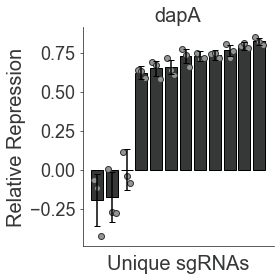

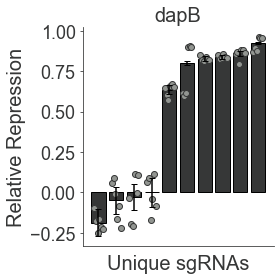

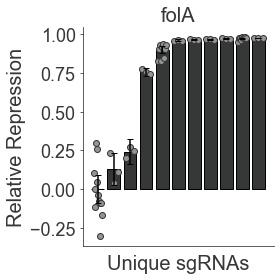

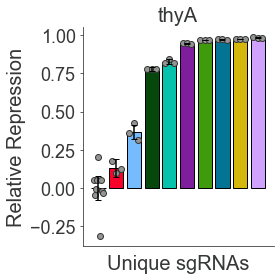

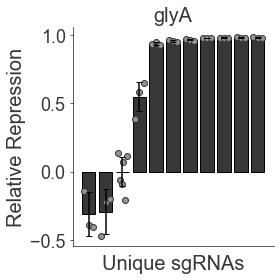

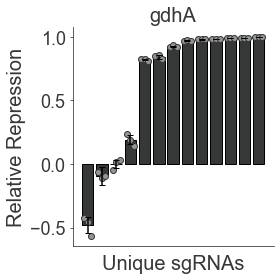

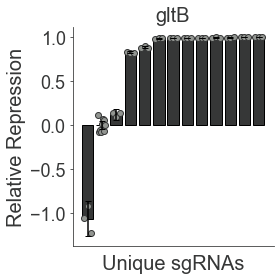

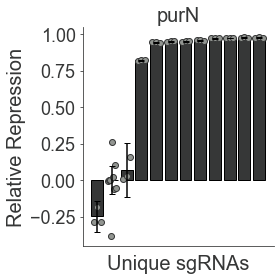

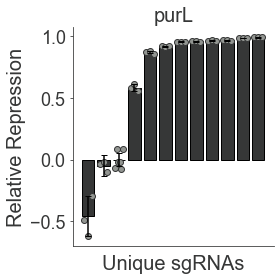

In [7]:
barplot_function(repression_dict, repression_mean_dict, repression_sem_dict, figure_path, {'thyA':'1D'})

### Export data and tables

In [8]:
with open(f'{output_path}/{date}_repression_mean.pickle', 'wb') as handle:
    pickle.dump(repression_mean_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{output_path}/{date}_repression_sem.pickle', 'wb') as handle:
    pickle.dump(repression_sem_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{output_path}/{date}_repression_std.pickle', 'wb') as handle:
    pickle.dump(repression_std_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{output_path}/{date}_repression_ind.pickle', 'wb') as handle:
    pickle.dump(repression_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{output_path}/{date}_repression_mean_subset.pickle', 'wb') as handle:
    pickle.dump(repression_mean_subset, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{output_path}/{date}_repression_sem_subset.pickle', 'wb') as handle:
    pickle.dump(repression_sem_subset, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{output_path}/{date}_repression_ind_subset.pickle', 'wb') as handle:
    pickle.dump(repression_ind_subset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
table_s1 = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Table S1', index_col='Unnamed: 0')
for i in table_s1.index:
    if table_s1.loc[i, 'sgRNA'] == 'Pathway Experiment':
        break
    sgRNA = table_s1.loc[i, 'sgRNA']
    seq = table_s1.loc[i, 'Homology Sequence']
    if sgRNA == 'nontargeting':
        table_s1.loc[i] = [sgRNA, seq, 0, 0, '', '']
    else:
        rep_eff = repression_mean_dict[sgRNA.split('_')[0]][sgRNA]
        rep_eff_sem = repression_sem_dict[sgRNA.split('_')[0]][sgRNA]
        table_s1.loc[i] = [sgRNA, seq, rep_eff, rep_eff_sem, '', '']
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:  
    table_s1.to_excel(writer, sheet_name='Table S1')